# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep conv net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an ipython notebook via learningsuite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 20% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracy
* 10% Reach 85% validation accuracy from parts 1-3
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**

**DONE:**
* ✅ Watch tutorial

In [ ]:
# =========
# 💡 Tip 💡
# =========
# To check how much memory your GPU has available, run

# !nvidia-smi

In [ ]:
# !nvidia-smi

Sun Jan 23 08:03:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    30W /  70W |   2894MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torch.nn.parameter import Parameter

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# pdb is a Python Debugger
# Set debugger trace, if needed, using pdb.set_trace()
import pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [ ]:
# ==========================================
# Use the dataset class you created in lab2
# ==========================================

# See: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# Create a dataset loader, inheriting from the torch.utils.data.Dataset class
class FashionMNISTProcessedDataset(Dataset):
    # root is the directory to save in
    def __init__(self, root, train=True):
        # See: https://pytorch.org/vision/stable/datasets.html#fashion-mnist
        self.data = datasets.FashionMNIST(
            root,
            train=True,
            transform = transforms.ToTensor(),
            download=True)
    
    def __getitem__(self, i):
        x, y = self.data[i]
        return x, y

    def __len__(self):
        return len(self.data)

___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropy loss function.

**TODO:**

**DONE:**
* ✅ Conv2D
* ✅ CrossEntropyLoss 
___

### Part 2
Implement a few initialization strategies which can include Xe initialization
(sometimes called Xavier), Orthogonal initialization, and uniform random.
You can specify which strategy you want to use with a parameter. 



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**

**DONE:**
* ✅ Orthogonal
* ✅ Parameterize custom Conv2D for different initilization strategies
* ✅ Uniform
* ✅ Xavier
* ✅ Plus, I added normal (standard normal distribution)



#### My notes
**Helpful tutorial on PyTorch modules:**

https://pytorch.org/docs/stable/notes/modules.html

**Also, extremely helpful explanations of super()**
* https://realpython.com/python-super/#an-overview-of-pythons-super-function
* https://stackoverflow.com/questions/576169/understanding-python-super-with-init-methods/27134600#27134600
* https://stackoverflow.com/questions/222877/what-does-super-do-in-python-difference-between-super-init-and-expl/33469090#33469090
* https://rhettinger.wordpress.com/2011/05/26/super-considered-super/

In [110]:
# For reproducibility, set seeds used for generating random numbers
random_number_generator_seed = 0

# PyTorch
# See: https://pytorch.org/docs/stable/notes/randomness.html#pytorch-random-number-generator
torch.manual_seed(random_number_generator_seed)

# Numpy
# See: https://numpy.org/doc/stable/reference/random/index.html?highlight=random#module-numpy.random
# And: https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f
np_randnum_gen = np.random.default_rng(random_number_generator_seed)

In [111]:
class CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean'):
        self.__dict__.update(locals())
        # Inherit from nn.Module using super()
        super().__init__()
    
    # Enable the object to be called after constructor, like this:
    # objective = nn.CrossEntropyLoss()
    # loss = objective(y_hat, y_truth)
    # See: https://docs.python.org/3/reference/datamodel.html#object.__call__
    # And: https://stackoverflow.com/a/21324981/17005348
    def __call__(self, y_pred, y_truth):
        # Helpful references:
        # Calculation: https://pytorch.org/docs/1.9.1/generated/torch.nn.CrossEntropyLoss.html
        # Logarithm properties: https://en.wikipedia.org/wiki/Logarithm#Product,_quotient,_power,_and_root

        # Calculate the numerator, which is -(score for the correct class)
        # See: https://youtu.be/3TAuTcx-VCc?t=3852
        rows = torch.arange(y_pred.size(0))
        cols = y_truth[:]
        scores_correct_labels = -1 * y_pred[rows, cols]

        # Calculate the denominator, which will be added to the numerator
        # (normally would be subtracted, but we are taking the -log(num/den),
        # which equals -log(num) + log(den)
        batch_demonimator = torch.logsumexp(input=y_pred, dim=1, keepdim=True)

        # Return the average across the batch
        # Dim 0 = batch, dim 1 = scores
        return torch.mean(scores_correct_labels + batch_demonimator)

    def forward(y_pred, y_truth):
        return self.__call__(y_pred, y_truth)


# See: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
class Conv2d(nn.Module):
    '''
    All parameters except `init` (for initialization) follow
    torch.nn.Conv2d.
    See: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

    `init`: {'xavier', 'orthogonal', 'normal', 'uniform'}, default='xavier'
    Sets the initialization strategy for the weights and biases. 
    '''
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
      padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros',
      device=None, dtype=None, init='xavier'):    
        # locals() is a dictionary of items that are defined in the current scope.
        # __dict__.update() merges the locals() dictionary with the dict from
        # the object that enables access to parameters in the format: self.property.
        # The line below is equivalent to: 
        # self.in_channels = in_channels
        # self.out_channels = out_channels ... etc. for all parameters
        self.__dict__.update(locals())

        # Inherit attributes and methods from the class (which in turn inherits from nn.Module)
        super().__init__()

        # weight parameter is a 4d tensor with dimensions
        # (output_channels, input_channels, kernel_height, kernel_width)
        # Parameter is a PyTorch tensor-like object that can hold gradient and other info
        self.weight = Parameter(torch.Tensor(
            out_channels,
            in_channels,
            *kernel_size))
        self.bias = Parameter(torch.Tensor(out_channels))

        # Initialize weights and biases
        # the .data returns the Tensor stored inside the Parameter object
        # num_weights = in_channels * kernel_height * kernel_width * out_channels
        num_weights = np.prod(self.weight.data.size())
        # input_weights = in_channels * kernel_height * kernel_width
        input_weights = np.prod((in_channels, *kernel_size))

        if init == 'orthogonal':
            # See: https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers#implementation
            rand_weights = np_randnum_gen.uniform(size=self.weight.data.size())
            U, _, Vt = np.linalg.svd(rand_weights, full_matrices=False)
            self.weight.data = torch.from_numpy(Vt.reshape(self.weight.data.size()).astype(np.float32))
            self.bias.data = torch.zeros(self.bias.data.size())
        elif init == 'normal':
            self.weight.data = torch.randn(self.weight.data.size())
            self.bias.data = torch.zeros(self.bias.data.size())
            # self.bias.data = torch.randn(self.bias.data.size())
        elif init == 'uniform':
            # See: https://pytorch.org/docs/stable/generated/torch.Tensor.uniform_.html
            # See also: https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.uniform_
            self.weight.data.uniform_(-1, 1)
            self.bias.data.uniform_(0, 0)
        else:
            # Assume 'xavier' by default
            # use Var = 2 / in_weights --> from end of post: https://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
            # See also: https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/
            # Standard deviation of the distribution
            distr_stdev = np.sqrt(2 / input_weights)
            self.weight.data = torch.from_numpy(np_randnum_gen.normal(loc=0.0, scale=distr_stdev, size=self.weight.data.size()).astype(np.float32))
            self.bias.data = torch.zeros(self.bias.data.size())
            # Alternative method, from Dr. Dan Ventura's slides
            # See: https://docs.google.com/presentation/d/1hqUb-5Phlp1UAmgt5JZ65Oxm-H9nOYDv/edit#slide=id.p54
            # self.weight.data = torch.from_numpy(
            #     np_randnum_gen.standard_normal(size=self.weight.data.size()) / np.sqrt(input_weights / 2))

    # Create forward function to pass data through layer.
    # pytorch.nn.functional is like layers (modules), 
    # but just provides the functions that do heavy lifting in neural networks
    # See: https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html
    def forward(self, x):
        return F.conv2d(x, self.weight, self.bias, self.stride,
                    self.padding, self.dilation, self.groups)
    
    # Set additional information when printing object (its 'representation')
    # Similar to Python's built-in: def __str__(self) and def __repr__(self) functions
    # See: https://www.kite.com/python/answers/how-to-create-a-custom-string-representation-for-a-class-object-in-python
    # Or: https://www.journaldev.com/22460/python-str-repr-functions
    def extra_repr(self):
        addl_info = 'in_channels: ' + str(self.in_channels)
        addl_info += ', out_channels: ' + str(self.out_channels)
        addl_info += ', kernel_size: ' + str(self.kernel_size)
        addl_info += ', stride: ' + str(self.stride)
        addl_info += ', padding: ' + str(self.padding)
        addl_info += ', initialization method: ' + str(self.init)
        return addl_info


In [116]:
class ConvNetwork(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        x, y = dataset[0]
        channels, height, width = x.size()
        # Fixed output of 10, for the 10 classes in FashionMNIST
        output = 10
        # See: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        # nn.Conv2d(input_channels, num_kernels, (kernel_height, kernel_width), padding=(pad_h, pad_w))
        # input_channel of second layer must equal output_channels (num_kernels) of first layer
        self.net = nn.Sequential(
            # Same output dimensions (c, w, h) as input dimensions based on kernel_size and padding
            Conv2d(channels, 64, (3,3), padding=(1,1), init='xavier'),
            nn.ReLU(),
            Conv2d(64, 128, (3,3), padding=(1,1), init='xavier'),
            nn.ReLU(),
            Conv2d(128, output, (28,28), padding=(0,0), init='xavier')
            # Output will be (num_items_in_batch, 10, 1, 1)
        )
    
    def forward(self, x):
        # Output is (batch_size, 10, 1, 1)
        # The line below collapses the 3rd element, then the 3rd element again
        # and the final dimensions are (batch_size, 10)
        return self.net(x).squeeze(2).squeeze(2)

In [117]:
# ===============================================
# Initialize the train and validation datasets
# ===============================================
train_dataset = FashionMNISTProcessedDataset(root='/tmp/fashionmnist', train=True)
val_dataset = FashionMNISTProcessedDataset(root='/tmp/fashionmnist', train=False)

In [118]:
# =======================
# Initialize DataLoaders
# =======================
# Create batches from the training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=100, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=100, pin_memory=True)

In [119]:
# ==================================================
# Initialize model, loss (objective), and optimizer
# ==================================================
model = ConvNetwork(train_dataset)
model = model.cuda()
# Set cost (loss) function to Cross Entropy Loss
objective = CrossEntropyLoss()
# The optimizer minimizes the cost function
optimizer = optim.Adam(params=model.parameters(), lr=1e-4)

In [120]:
# ==================================================
# Run training and validation loop and collect stats
# ==================================================
# An epoch ends when all batches of training data have been processed
num_epochs = 1
total_batches = len(train_loader) * num_epochs
epoch_pbar = tqdm(total=total_batches, position=0, leave=False)

# Capture loss information on model performance (train and validation)
train_losses = []
val_losses = []
# Capture accuracy information on model performance
train_acc = []
val_acc = []

for epoch in range(num_epochs):
    batch_pbar = tqdm(total=len(train_loader), position=1, leave=False)
    for batch, (x, y_truth) in enumerate(train_loader):
        # Load tensors on GPU
        x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)
        # Zero-out gradient information so it can be updated
        optimizer.zero_grad()
        # Make predictions
        y_hat = model(x)
        # Calculate loss
        loss = objective(y_hat, y_truth)
        # Compute backpropagation
        loss.backward()
        # Capture loss information
        train_losses.append(loss.item())
        # Measure accuracy
        # See: https://youtu.be/3TAuTcx-VCc?t=3968
        train_acc.append((torch.softmax(y_hat, 1).argmax(1) == y_truth).float().mean().item())
        # Update progress bars by 1 step
        epoch_pbar.set_description(f'Epoch: {epoch+1}/{num_epochs}, Acc: {train_acc[-1]:.0%}, Loss: {loss.item():.3f}')
        epoch_pbar.update(n=1)
        batch_pbar.set_description(f'Batch loop: batch {batch}/{len(train_loader)}')
        batch_pbar.update(n=1)
        # Take step, based on learning rate and gradient
        optimizer.step()

        # Calculate validation metrics
        if batch % 100 == 0:
            val_batch_losses = []
            val_batch_acc = []
            val_batch_pbar = tqdm(total=len(val_loader), position=2, leave=False)
            val_batch_pbar.set_description('Validation loop')
            for val_x, val_y_truth in val_loader:
                val_x, val_y_truth = val_x.cuda(non_blocking=True), val_y_truth.cuda(non_blocking=True)
                val_batch_losses.append(objective(model(val_x), val_y_truth).item())
                val_y_hat = model(val_x)
                val_batch_acc.append((val_y_hat.argmax(1) == val_y_truth).float().mean().item())
                # Update progress bar by 1 step
                val_batch_pbar.update(n=1)
            val_losses.append((len(train_losses), np.mean(val_batch_losses)))
            val_acc.append((len(train_acc), np.mean(val_batch_acc)))
            val_batch_pbar.close()
            # List comprehension alternative to the for loop.
            # Unfavored because it loops through val_loader twice.
            # ------------------------------------
            # # Avg loss across all batches in validation set
            # val = np.mean([objective(model(x.cuda()), y_truth.cuda()).item() 
            #                 for x, y_truth in val_loader])
            # val_losses.append((len(losses), val))
            # # Avg accuracy for all batches in validation set
            # val_accuracy = np.mean([(model(x.cuda()).argmax(1) == y_truth.cuda()).float().mean() for x, y_truth in val_loader])
            # val_acc.append((len(train_acc), val_accuracy))
    batch_pbar.close()
epoch_pbar.close()    

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]


___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

Once you've experimented with multiple network setups and the different initialization strategies, plot the best-performing experiment here. You should be able to exceed 85% accuracy on the validation set.

**TODO:**

**DONE:**
* ✅ Experiment with Deep Networks
* ✅ Plot experiment results with 85% or better validation accuracy
* ✅ Plot accuracy of training and validation set over time
* ✅ Print out number of parameters in the model 

In [ ]:
# Go back up and try a few different networks and initialization strategies
# Plot loss if you want
# Plot accuracy

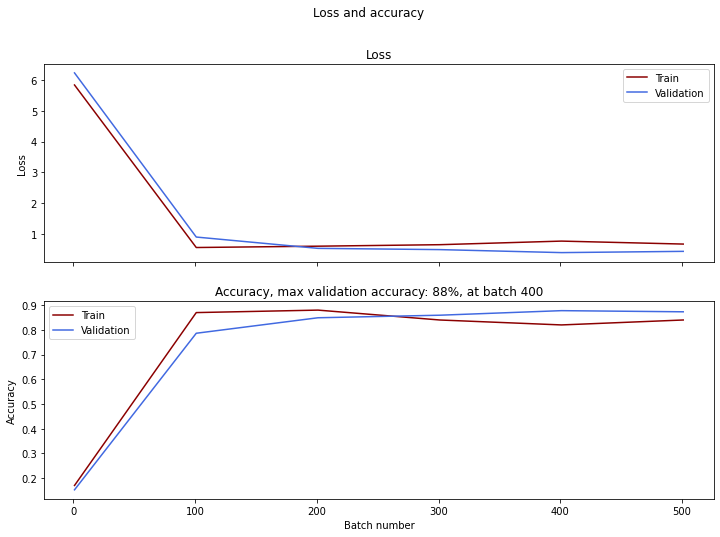

In [122]:
# ========================
# Plots: loss and accuracy
# ========================
# Use plt.subplots() to create two plots, stacked vertically
# See: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# And: https://www.w3schools.com/python/matplotlib_subplots.asp

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(12,8))

# Loss
val_xs, val_ys = zip(*val_losses)
# Optional: smooth chart by removing some data points
train_losses_chart = []
for i in val_xs:
    train_losses_chart.append(train_losses[i])
ax1.plot(val_xs, train_losses_chart, label='Train', c='darkred')
# Alternative:
# ax1.plot(train_losses, label='Train', c='darkred')
ax1.plot(val_xs, val_ys, label='Validation', c='royalblue')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss')

# Accuracy
val_xs, val_ys = zip(*val_acc)
# Optional: smooth chart by removing some data points
train_acc_chart = []
for i in val_xs:
    train_acc_chart.append(train_acc[i])
ax2.plot(val_xs, train_acc_chart, label='Train', c='darkred')
# Alternative:
# ax2.plot(train_acc, label='Train', c='darkred')
ax2.plot(val_xs, val_ys, label='Validation', c='royalblue')
ax2.set_xlabel('Batch number')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title(f'Accuracy, max validation accuracy: {max(val_ys):.0%}, at batch {val_xs[val_ys.index(max(val_ys))] - 1}')

fig.suptitle('Loss and accuracy')
plt.show()

In [123]:
# Compute and print the number of parameters in the model
# View the number of parameters
# torch.numel = number of elements
num_params = sum([torch.numel(layer) for layer in model.parameters()])

# Alternative form, using np.prod
# num_params = sum([np.prod(layer.size()) for layer in model.parameters()])

print(f'Total parameters: {num_params:,d}')

Total parameters: 1,078,026


In [107]:
model.net[0].weight.size()

torch.Size([64, 1, 3, 3])

In [121]:
model

ConvNetwork(
  (net): Sequential(
    (0): Conv2d(in_channels: 1, out_channels: 64, kernel_size: (3, 3), stride: 1, padding: (1, 1), initialization method: orthogonal)
    (1): ReLU()
    (2): Conv2d(in_channels: 64, out_channels: 128, kernel_size: (3, 3), stride: 1, padding: (1, 1), initialization method: normal)
    (3): ReLU()
    (4): Conv2d(in_channels: 128, out_channels: 10, kernel_size: (28, 28), stride: 1, padding: (0, 0), initialization method: xavier)
  )
)

In [92]:
for layer in model.parameters():
    print(layer.size())

torch.Size([64, 1, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([10, 128, 28, 28])
torch.Size([10])


In [93]:
model.net[0]

Conv2d(in_channels: 1, out_channels: 64, kernel_size: (3, 3), stride: 1, padding: (1, 1), initialization method: xavier)

___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.

---
#### My formulas

**Formula for padding size**

$paddingDim = \frac{outputDim - inputDim + kernelDim -1}{2}$

**Formula for output dimension**

$outputDim = inputDim + (paddingDim * 2) - kernelDim + 1$

---

*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernel_size=(3, 3), padding=(1, 1))**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **(out_channels=65, kernel_size=(3, 3), padding=(2, 2))**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **(out_channels=7, kernel_size=(3, 3), padding=(6, 6))**

*Using a Kernel size of 5×5:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5, 5), padding=(2, 2))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5, 5), padding=(3, 3))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5, 5), padding=(9, 9))**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **(out_channels=10, kernel_size=(5, 3), padding=(1, 0))**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5, 3), padding=(2, 1))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5, 3), padding=(3, 2))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5, 3), padding=(9, 8))**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **(out_channels=10, kernel_size=(2, 4), padding=(0, 0))**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernel_size=(3, 3), padding=(1, 1))**

**TODO:**

**DONE:**
* ✅ Answer all the questions above 


In [ ]:
# Write some test code for checking the answers for these problems (example shown in the video)
batch_size = 1

# ==================
# Inputs
# ==================
in_channels = 3
in_height = 10
in_width = 10

out_channels = 7
out_height = 20
out_width = 20

# Kernel and padding size
k_size = (3, 3)
p_size = (6, 6)

# ===================

test_conv = nn.Conv2d(in_channels, out_channels, 
                      kernel_size=k_size, padding=p_size)
print('Expected:', 
      torch.zeros(batch_size, out_channels, out_height, out_width).size())
print('Result:  ', 
      test_conv(torch.zeros(batch_size, in_channels, in_height, in_width)).size())

Expected: torch.Size([1, 7, 20, 20])
Result:   torch.Size([1, 7, 20, 20])
